# Evaluation
This notebook is for inspecting the data and produce the desired results. It will use dataframes to do so.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import sys, os, csv, re
import numpy as np
os.chdir("..")

# sys.path.insert(0,'..')
import src.parse as parse
from src.plot import plot_all, automatic_plotting

In [2]:
files = [file.rstrip(".vrp") for file in os.listdir("Instances/Uchoa") if (not file.endswith("sol"))]

methods = ["SPPRC","cyc2","ng8","ng20"]

In [6]:
dfs = {}
columns = ["ID",'instance','method','terminated','n',"K",'total time','sol_val']
finished_columns = ['final bound']
data = pd.DataFrame(columns=columns + finished_columns)
pattern = r"(X-n(\d+)-k(\d+))-(\w+)\.log"
for i, log in enumerate((log for log in os.listdir("output_uchoa"))):
    ID = log.strip(".log")
    instance, n, K, method = re.search(pattern, log).groups()
    log = f"output_uchoa/{log}"
    finished = parse.log_finished(log)
    sol_val = parse.parse_sol_val(instance)
    
    df = parse.parse_output(log)
    df["total time"] = df["total time"].cumsum()
    df = df[df.method == method]
    dfs[f'{instance}-{method}'] = df
    if finished:
        data = pd.concat((data,pd.DataFrame([[ID, instance,method, finished,n,K, df['total time'].iloc[-1], sol_val, df['upper_bound'].iloc[-1]]],columns=columns+finished_columns)))
    else:
        data = pd.concat((data,pd.DataFrame([[ID, instance,method, finished,n,K, df['total time'].iloc[-1], sol_val]],columns=columns)))
data = data.set_index("ID")
data['total time'] = data['total time'].astype(float)
data['n/K'] = data['n'].astype(float) / data['K'].astype(float)
data['lb/I'] = data['final bound'].astype(float) / data['sol_val'].astype(float)

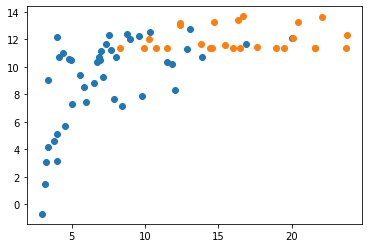

In [108]:
df = data.loc[data.method == "ng20"].copy()
df['div'] = df['n'].astype(float) / df['K'].astype(float)
df1 = df.loc[df.terminated == True]
df2 = df.loc[df.terminated == False]
# plt.scatter(df['div'],np.log(df['total time']))
# df2.sort_values("div")
plt.scatter(df1['div'],np.log(df1['total time']))
plt.scatter(df2['div'],np.log(df2['total time']))
#TODO: Hier vier Subplots machen, die jeweils die Laufzeiten angeben für die vier Methoden

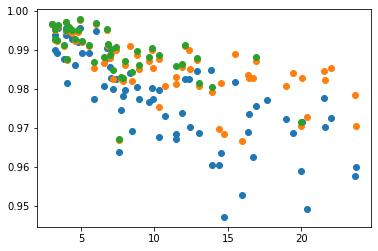

In [20]:
# Die Bound Qualität scheint zu sinken, je höher n/K ist.
df1 = data[data.method == "cyc2"]
df2 = data[data.method == "ng8"]
df3 = data[data.method == "ng20"]
plt.scatter(df1["n/K"],df1['lb/I'])
plt.scatter(df2["n/K"],df2['lb/I'])
plt.scatter(df3["n/K"],df3['lb/I'])
plt.show()

## Create Table

In [111]:
hierarchy = {"ng20":"ng8","ng8":"cyc2","cyc2":"SPPRC"}
data['I'] = np.nan #pd.Series(np.nan,dtype=pd.Int64Dtype())
data['t'] = np.nan
data['lb_rel'] = np.nan
# for index, row in data[data.instance == "X-n502-k39"].iterrows():
for index, row in data.iterrows():
    if row['terminated']:
        df = dfs[index]
        if row['method'] in hierarchy.keys():
            instance = row["instance"]
            method = row["method"]
            bound_sup = data['final bound'][f"{instance}-{hierarchy[method]}"]
            data.loc[index,'lb_rel'] = bound_sup / row['final bound']
            df_beaten = df[df['lower_bound'] >= bound_sup]
#             print(df_beaten)
            data.loc[index, 'I'] = df_beaten.shape[0] - 1
            data.loc[index, 't'] = df_beaten['total time'].iloc[-1] - df_beaten.iloc[0,df_beaten.columns.get_loc('total time')]
#             print(f"First time{df_beaten['total time'].iloc[-1]}")
data["t/I"] = data['t'] / (data["I"])
data["%"] = data['t'].divide(data['total time'],fill_value=np.nan)
# data["%"] = (data["%"] * 100).round(0).astype(str) + "%"
data["tt"] = data['total time']
data = data.round({"total time":0, "t":0,"%":2,"t/I":0})

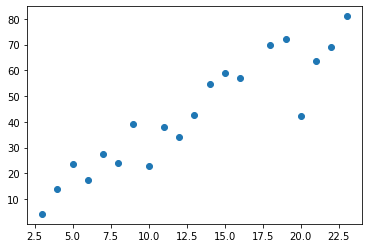

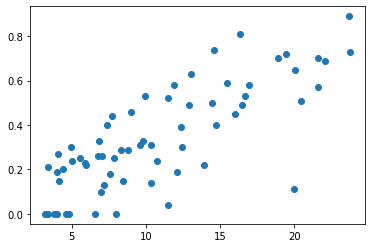

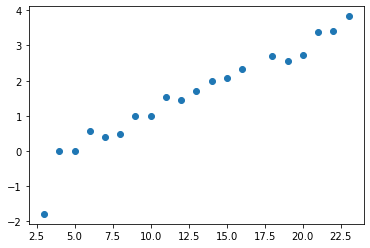

In [95]:
table = data[['instance','method','I','t','tt',"%","t/I","n/K"]]
table = table[table.method != "SPPRC"]
# table = table[table.method == "ng8"]
table["n/K"] = table["n/K"].astype(int)
table["%"] = (table["%"]*100)
table = table.groupby(["n/K","method"]).mean().unstack('method')
table.columns = table.columns.swaplevel()
_, index = table.columns.sortlevel()
table = table.iloc[:,index]
# ser = table[("","n/K")]
table = table[['cyc2','ng8','ng20']]
# table.style.format("{:.0f}")
plt.scatter(table.index,table['ng8',"%"])
plt.show()
# Die Streuung scheint unterschiedlich groß zu sein! Bei n8 etwas kleiner, ber cyc2 deutlich größer
subset = data[data.method == "ng8"]
plt.scatter(subset["n/K"],subset["%"])
plt.show()
plt.scatter(table.index,np.log(table['ng8',"I"]))
plt.show()
# Das ganze scheint ebenso für cyc2 und % zu gelten.
# Aber nicht für ng20!

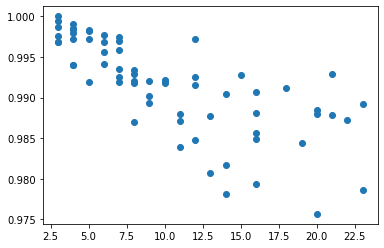

In [114]:
df = data.copy()
df["n/K"] = df["n/K"].astype(int)
df = df[df.method == 'ng8']
plt.scatter(df['n/K'],df['lb_rel'])

In [59]:
table = data[['instance','method','I','t','tt',"%","t/I","n/K"]]
table = table[table.method != "SPPRC"]
table = table.pivot(index=["instance","n/K"],columns='method')
table = table.reset_index("n/K")
table.columns = table.columns.swaplevel()
_, index = table.columns.sortlevel()
table = table.iloc[:,index]
ser = table[("","n/K")]
table = table[['cyc2','ng8','ng20']]
table.insert(0,"n/K",ser)
# # format_dict = {("ng8","%"):"{:.0%}".format, ("ng20","%"):"{:.0%}".format, ("cyc2","%"):"{:.0%}".format}
# # table.iloc[:46].to_latex("output/table_small.tex",formatters=format_dict,float_format="%.0f",na_rep="-")
# # table.iloc[46:].to_latex("output/table_large.tex",formatters=format_dict,float_format="%.0f",na_rep="-")
table.style.format("{:.0f}")